In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13,8)
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# APEX Gun example

In [3]:
import sys, os
root = os.path.join(os.getcwd(), '../')

sys.path.append(root)

INPUT_FILE = os.path.join(root,'templates/apex_gun/gpt.in')

from gpt import GPT

In [4]:
G = GPT(input_file=INPUT_FILE, verbose=True)

Configured to run in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpzrcxhsk1


In [5]:
# Set some of these
variables_were_set = G.set_variables({'gun_peak_field':20e6,'gun_phase':0,'tmax': 4e-7, 'RadiusMax':.015,
                                      'Ntout':2000,
                                     'dtmin':0,
                                     'GBacc':8,
                                       'xacc':8
                                     })
print(variables_were_set)

[True, True, True, True, True, True, True, True]


In [6]:
# Run
G.run()
print(G)
print('\nNumber of touts:',len(G.tout))

init dir:  /Users/chrisonian/Code/GitHub/lume-gpt/examples
running GPT in /private/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpzrcxhsk1

General Particle Tracer - Oct 28 2014
Run Aborted: Cannot identify species with mass 1.6735575e-27 and charge 1.602e-19
GPT object:
   Original input file: gpt.in
   Use temp directory: True
   Work directory: None

Run Control
   Run configured: True
   Using temp directory: False
   Timeout: None (sec)

Results
   Finished: True
   Error occured: True
   Run time: 2.644879102706909 (sec)

Number of touts: 1565


# Plot trajectories

In [7]:
import numpy as np
from matplotlib import pyplot as plt

# Make trajector structure here for now, should go somewhere else as a function

print(G.tout[0].keys())

rs ={}
for t in G.tout:
    for ID in t['ID']:
        idint=int(ID)
        res = np.where(t['ID']==ID)
        index = res[0][0]
        
        if(ID not in rs.keys()):
            rs[idint]={'x':[],'y':[],'z':[], 't':[], 'GBz':[]}
        else:
            rs[idint]['x'].append(t['x'][index])
            rs[idint]['y'].append(t['y'][index])
            rs[idint]['z'].append(t['z'][index])
            rs[idint]['t'].append(t['t'][index])
            rs[idint]['GBz'].append(t['GBz'][index])
         

dict_keys(['x', 'GBx', 'y', 'GBy', 'z', 'GBz', 't', 'q', 'nmacro', 'ID', 'm', 'w', 'G', 'time', 'n', 'number'])


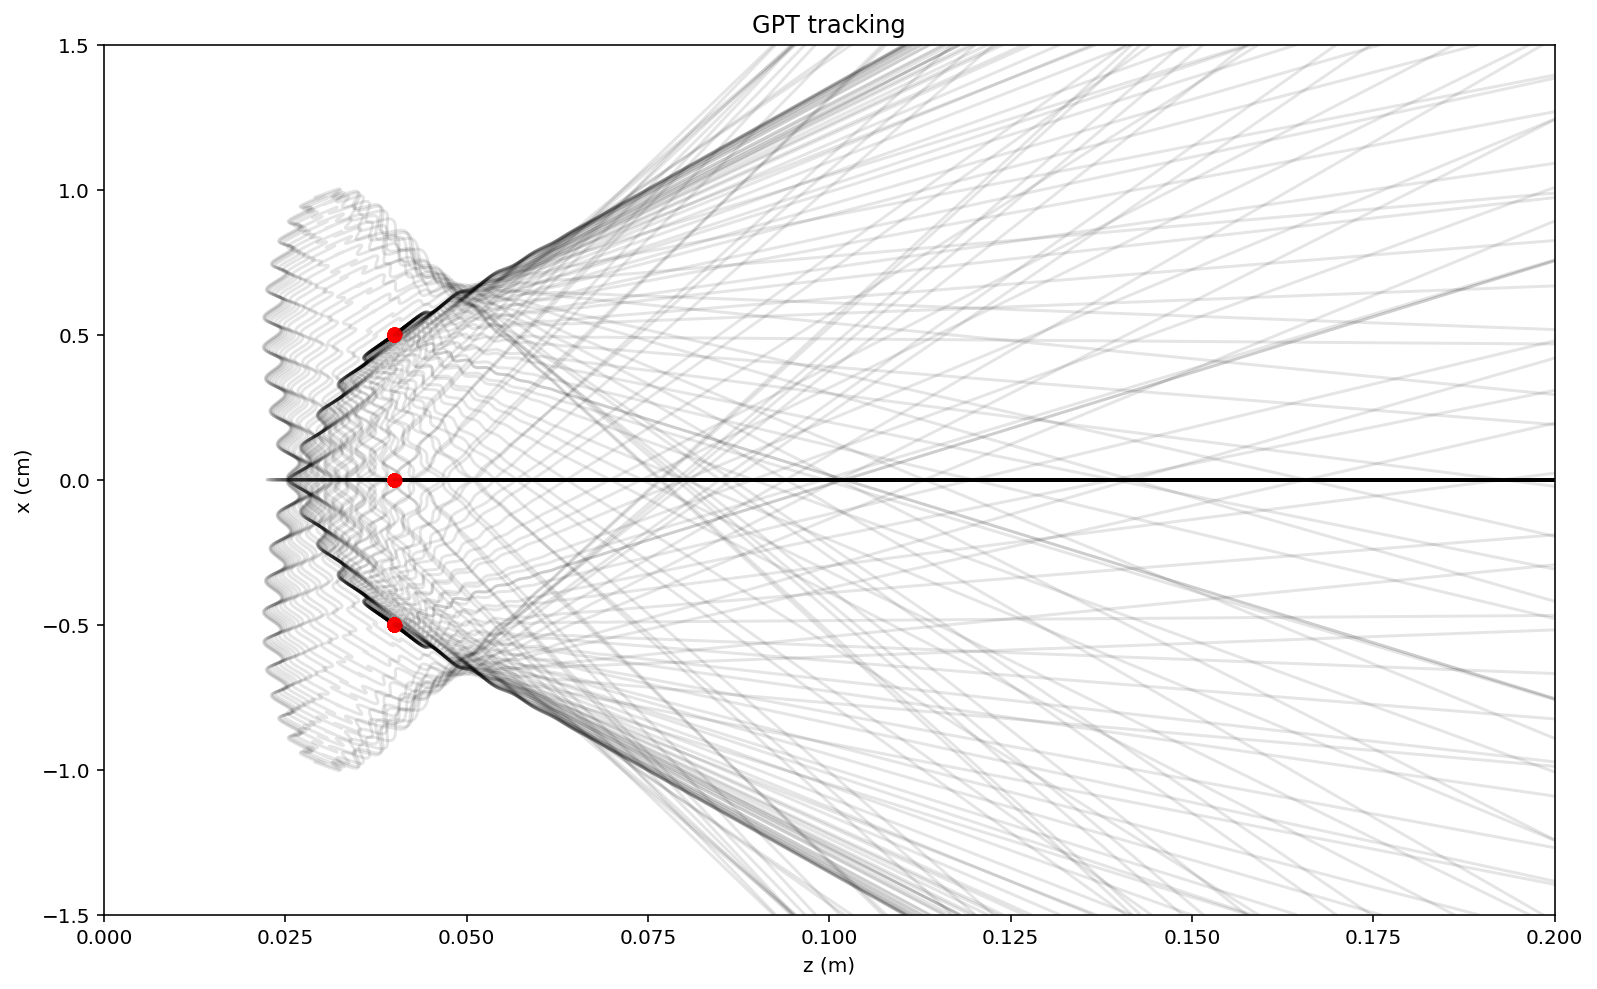

In [8]:
for ind in rs.keys():
    for var in rs[ind]:
        rs[ind][var]=np.array(rs[ind][var])

for ind in rs.keys():
    plt.plot(rs[ind]['z'][0],rs[ind]['x'][0]*1e2, color='red', marker='o')
    plt.plot(rs[ind]['z'],rs[ind]['x']*1e2, color='black', alpha=0.1)

plt.ylim(-1.5, 1.5)
plt.xlim(0, 0.2)
plt.title('GPT tracking')
plt.xlabel('z (m)');
plt.ylabel('x (cm)');

In [9]:
rs[1].keys()

dict_keys(['x', 'y', 'z', 't', 'GBz'])

In [10]:
G.get_gpt_output_file()

'/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpzrcxhsk1/gpt.out.gdf'

In [11]:
G.input_file

'/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpzrcxhsk1/gpt.in'

In [12]:
!ls -al /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpcdkj39ma

ls: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpcdkj39ma: No such file or directory
